Check the total percentage of missing values of full dataset after dropping columns with more than 70% of missing values

Sensor Component Failure Prediction

1) Problem statement.
Data: Sensor Data

Problem statement :

.)The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

.)The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

#True class	Positive	Negative	
Predicted class			
Positive	-	cost_1	
Negative	cost_2		
Cost 1 = 10 and Cost 2 = 500

.)The total cost of a prediction model the sum of Cost_1 multiplied by the number of Instances with type 1 failure and Cost_2 with the number of instances with type 2 failure, resulting in a Total_cost. In this case Cost_1 refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while Cost_2 refer to the cost of missing a faulty truck, which may cause a breakdown.

.) Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.

.)From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly         we have to reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.  

Challenges and other objectives
.) Need to Handle many Null values in almost all columns
.) No low-latency requirement.
.) Interpretability is not important.
.) misclassification leads the unecessary repair costs.

2) Import required libraries

In [6]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [7]:
import sys
import os
import sklearn

ModuleNotFoundError: No module named 'sklearn'

In [8]:

pip install scikit-learn

     |████████████████████████████████| 9.8 MB 22.3 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 67.1 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 68.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip3 install xgboost

     |████████████████████████████████| 193.6 MB 151 kB/s  eta 0:00:01


In [ ]:
pip install catboost

     |████████████████████████████████| 76.6 MB 85.5 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 15.2 MB 68.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pyplot
import statistics as mean
import warnings
from sklearn.preprocessing import PowerTransformer

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay, \
    precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix

In [12]:
from sklearn import metrics
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from catboost import CatBoostClassifier




ModuleNotFoundError: No module named 'catboost'

In [ ]:
warnings.filterwarnings("ignore")
%matplotlib inline

In [13]:

import pandas as pd 

Read Data
# load csv dataset


In [14]:
df=pd.read_csv("/config/workspace/aps_failure_training_set1.csv",na_values="na")
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,182.0,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2926.0,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN


In [15]:
# Check Rows and Columns of Dataset
df.shape

(36188, 171)

In [16]:
# Check unique values of target variable
df['class'].value_counts()

neg    35188
pos     1000
Name: class, dtype: int64

In [17]:
#Define numerical and categorical columns

numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']




In [18]:
# print columns
print('we have {} numerical_features :{}'.format (len(numeric_features), numeric_features))

we have 170 numerical_features :['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000',

In [19]:
print('we have {} categorical_features:{}'.format (len(categorical_features),categorical_features))

we have 1 categorical_features:['class']


AS THIS IS SENSOR DATA. INTERPRETATION OF THE DATA IS NOT REQUIRED

CHECKING MISSING VALUES

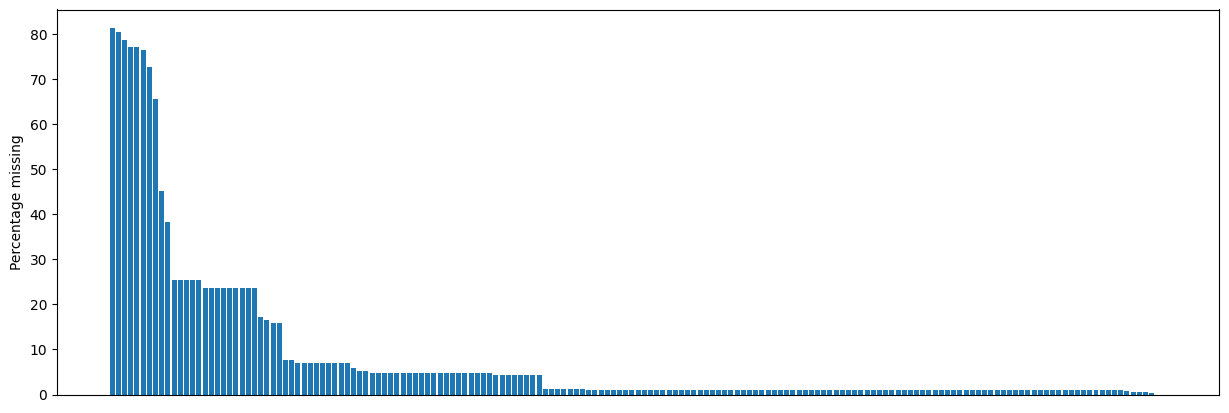

In [20]:
# Plotting Missing values count for each column
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

Dropping columns which have more then 70% of missing values

In [21]:
#Dropping columns which have more then 70% of missing values
dropcols=missing[missing[0]>70]
dropcols

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [22]:
df.drop(list(dropcols.index),axis=1,inplace=True)

In [23]:
# Check shape of dataset after dropping the missing columns
df.shape

(36188, 164)

In [24]:
 missing_values_count= df.isnull().sum()
 total_cells=np.product(df.shape)
 total_missing=missing_values_count.sum()
 

In [25]:
# Percentage of data that is missing
print(f"percentage of total missing cells in the data {(total_missing/total_cells) *100}%")

percentage of total missing cells in the data 5.37059852747306%


Visualization of unique values in target variable


positive:1000,Negative:35188


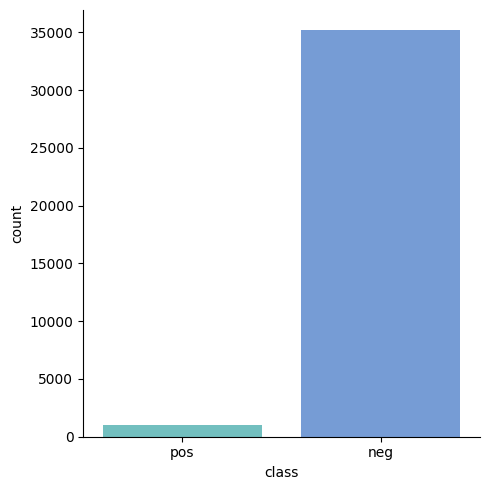

In [30]:
pos=df[df['class']=='pos'].shape[0]
neg=df[df['class']=='neg'].shape[0]
print("positive:" +str(pos) + ",Negative:" + str(neg))
sns.catplot(data=df,x="class", kind= "count", palette="winter_r", alpha =0.6 )
plt.show()